# Google Stock Price Prediction using ARIMA & SARIMA

**If the data is stationary, we need to use ARIMA, if the data is seasonal, we need to use Seasonal ARIMA (SARIMA).**

I will first collect Google stock price data using the Yahoo Finance API.

Yahoo Finance is one of the most popular websites to collect stock price data. You need to visit the website, enter the company’s name or stock symbol, and you can easily download the dataset. But if you want to get the latest dataset every time you are running your code, you need to use the yfinance API. yfinance is an API provided by Yahoo Finance to collect the latest stock price data.

To use this API, you need to install it by using the pip command in your terminal or command prompt as mentioned below:

pip install yfinance

In [147]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=360)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG',
                      start=start_date,
                      end=end_date,
                      progress=False)
print(data.head(1))
print(data.tail(1))

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-20  123.535004  125.175003  122.830002  123.849998  123.709221   

              Volume  
Date                  
2023-06-20  22698000  
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-06-10  176.449997  178.470001  174.380005  176.630005  176.630005   

              Volume  
Date                  
2024-06-10  17099800  


In [148]:
data.shape

(246, 6)

In [149]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,246.000000,246.000000,246.000000,246.000000,246.000000,2.460000e+02
mean,142.095878,143.575256,140.865984,142.296545,142.135618,2.185077e+07
std,15.177883,15.240585,15.087843,15.248500,15.233018,8.030350e+06
min,116.760002,118.224998,115.830002,116.870003,116.737160,8.828600e+06
25%,131.972500,133.509998,130.775002,131.902500,131.752571,1.723805e+07
50%,138.509995,139.939995,137.519997,138.714996,138.557327,1.953640e+07
75%,149.497494,151.152496,148.107498,149.444996,149.275127,2.365405e+07
max,178.779999,179.949997,177.309998,179.539993,179.335922,5.879610e+07


In [150]:
data.index

DatetimeIndex(['2023-06-20', '2023-06-21', '2023-06-22', '2023-06-23',
               '2023-06-26', '2023-06-27', '2023-06-28', '2023-06-29',
               '2023-06-30', '2023-07-03',
               ...
               '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31',
               '2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06',
               '2024-06-07', '2024-06-10'],
              dtype='datetime64[ns]', name='Date', length=246, freq=None)

The above code will collect the stock price data from today to the last 360 days. In this dataset, Date is not a column, it’s the index of this dataset. To use this data for any data science task, we need to convert this index into a column. Below is how you can do that:

In [151]:
data["Date"] = data.index
data = data[["Date", "Open", "High",
             "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.head())

        Date        Open        High         Low       Close   Adj Close  \
0 2023-06-20  123.535004  125.175003  122.830002  123.849998  123.709221   
1 2023-06-21  123.235001  123.410004  120.860001  121.260002  121.122169   
2 2023-06-22  120.660004  123.934998  119.599998  123.870003  123.729202   
3 2023-06-23  122.040001  123.440002  121.860001  123.019997  122.880165   
4 2023-06-26  121.466003  122.720001  118.989998  119.089996  118.954628   

     Volume  
0  22698000  
1  22612000  
2  20781900  
3  29542900  
4  23185000  


If you want to get the latest dataset every time you are running your code, you need to use the yfinance API.

We only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further:

In [152]:
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2023-06-20  123.849998
1 2023-06-21  121.260002
2 2023-06-22  123.870003
3 2023-06-23  123.019997
4 2023-06-26  119.089996


Now let’s visualize the close prices of Google before moving forward:



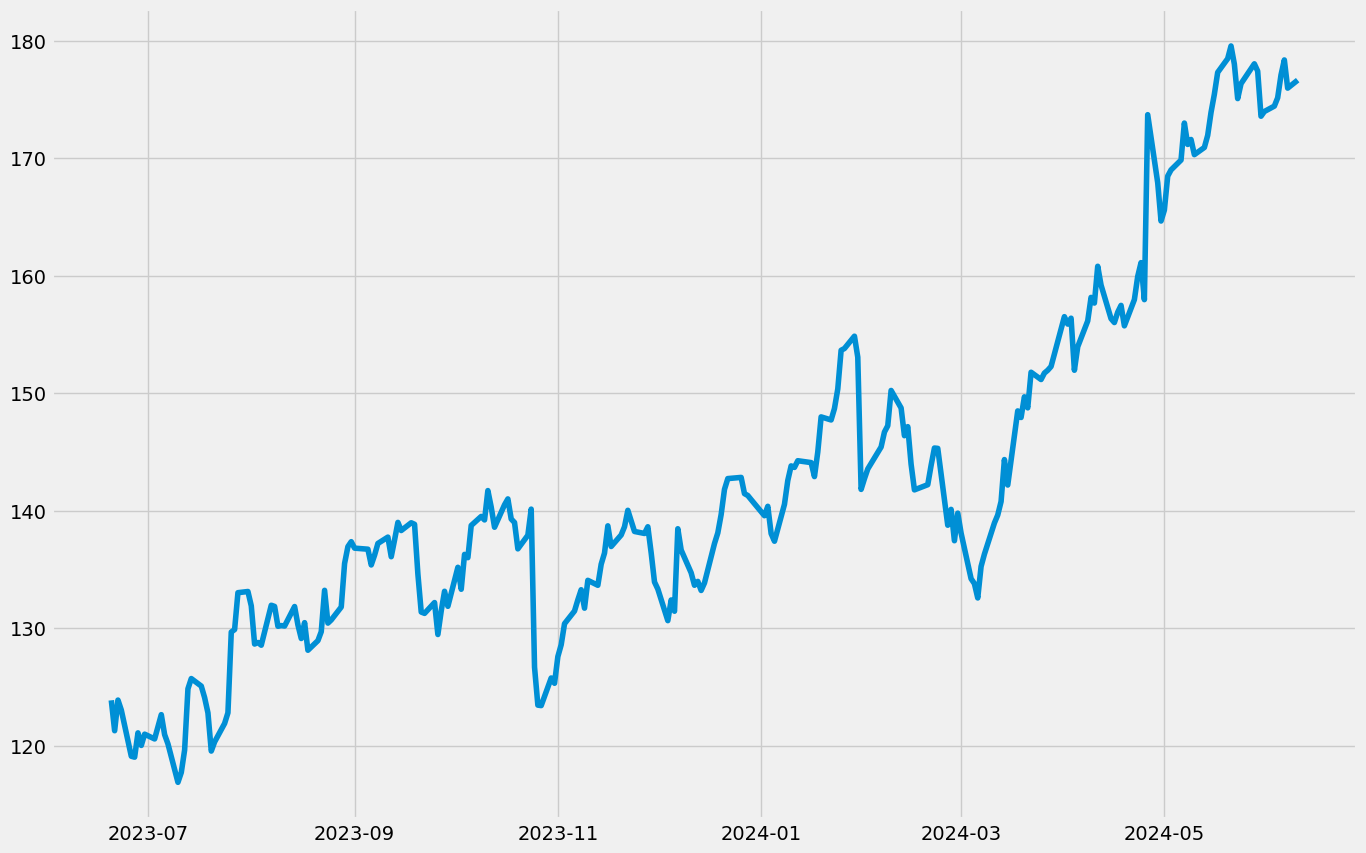

In [153]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

Before using the ARIMA model, we have to figure out whether our data is stationary or seasonal. The data visualization graph about the closing stock prices above shows that our dataset is not stationary.

To check whether our dataset is stationary or seasonal properly, we can use the **seasonal decomposition method** that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data:

<Figure size 640x480 with 0 Axes>

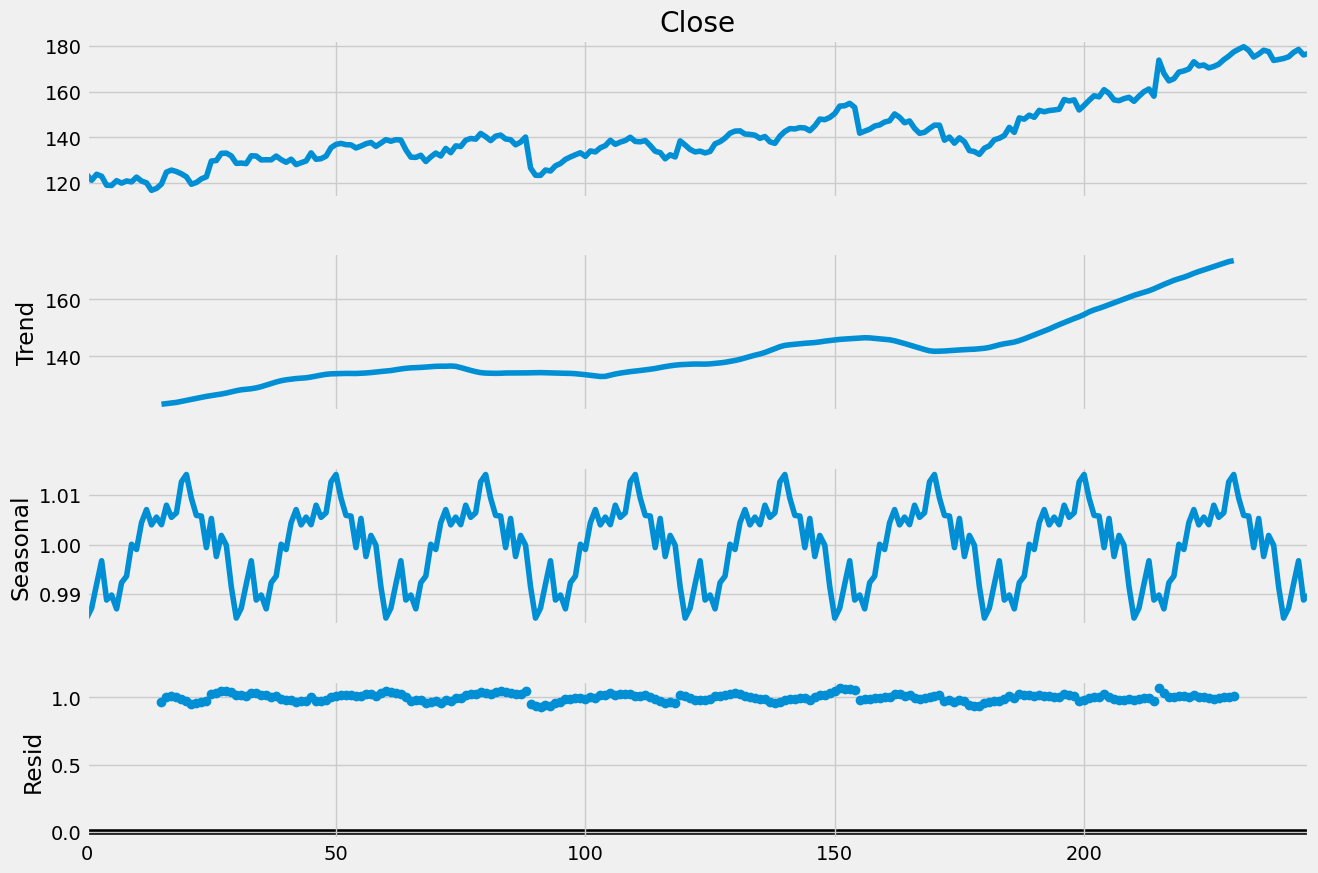

In [154]:
# To figure out whether our data is stationary or seasonal
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"],
                            model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 10)


Seasonal Decomposition of Time Series (STL Decomposition)
This method decomposes the time series into trend, seasonal, and residual components, which helps to visually identify seasonality and trends.

Interpretation of Decomposition


* Trend Component: If a trend is present, it indicates a **long-term increase or decrease** in the data.

* Seasonal Component: If the seasonal component is **significant and repetitive**, it indicates seasonality.

* Residual Component: The remaining part after removing the trend and seasonality, which should ideally be stationary. (should have a constant mean and variance over time and no predictable patterns.)

Seasonal plot has a significant and repetitive pattern so data is seasonal.

And also can use the ADF test to check for
stationarity after each differencing step. (extra)

In [155]:
from statsmodels.tsa.stattools import adfuller

# Original series
adf_result = adfuller(data["Close"])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# First differencing
data_diff1 = data["Close"].diff().dropna()
adf_result_diff1 = adfuller(data_diff1)
print('ADF Statistic (1st diff):', adf_result_diff1[0])
print('p-value (1st diff):', adf_result_diff1[1])

# Second differencing if needed
data_diff2 = data_diff1.diff().dropna()
adf_result_diff2 = adfuller(data_diff2)
print('ADF Statistic (2nd diff):', adf_result_diff2[0])
print('p-value (2nd diff):', adf_result_diff2[1])

ADF Statistic: -0.5945908511231129
p-value: 0.8721995944317409
ADF Statistic (1st diff): -16.91670474107567
p-value (1st diff): 1.0011451415354666e-29
ADF Statistic (2nd diff): -9.631606337269528
p-value (2nd diff): 1.606662783730833e-16


Typically, a p-value less than 0.05 indicates that the series is stationary.

### What is ARIMA?


ARIMA stands for Autoregressive Integrated Moving Average. It is an algorithm used for forecasting Time Series Data. ARIMA models have three parameters like ARIMA(p, d, q). Here p, d, and q are defined as:

* **p** - The order of the **AutoRegressive (AR)** component, which captures the relationship between the current value and its past values.

* **d** - represents the number of times the data needs to differentiate to produce a stationary signal. If it’s stationary data, the value of d should be 0, and if it’s seasonal data, the value of d should be 1. d captures the **integrated (I)** part of ARIMA.

* **q** - The order of the **Moving Average (MA)** component, which accounts for the impact of past error terms on the current value.

We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. But before using the SARIMA model, we will use the ARIMA model. It will help learn using both models.

To use ARIMA or SARIMA, we need to find the p, d, and q values.


https://thecleverprogrammer.com/2023/06/13/how-to-calculate-p-d-and-q-values-using-python/

https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling

Example:

Scenario: Imagine you're analyzing monthly sales data. The ACF plot shows significant spikes at lags 1 and 2, followed by insignificant spikes at remaining lags. The PACF plot shows a significant spike at lag 1 and insignificant spikes at all other lags.

Interpretation:

From the ACF, the dependence on past values seems to **diminish (become less)** after lag 2, suggesting a possible MA(2) term.
The PACF with a **single significant** spike at lag 1 implies an AR(1) term might be sufficient.

Find the value of q (MA):

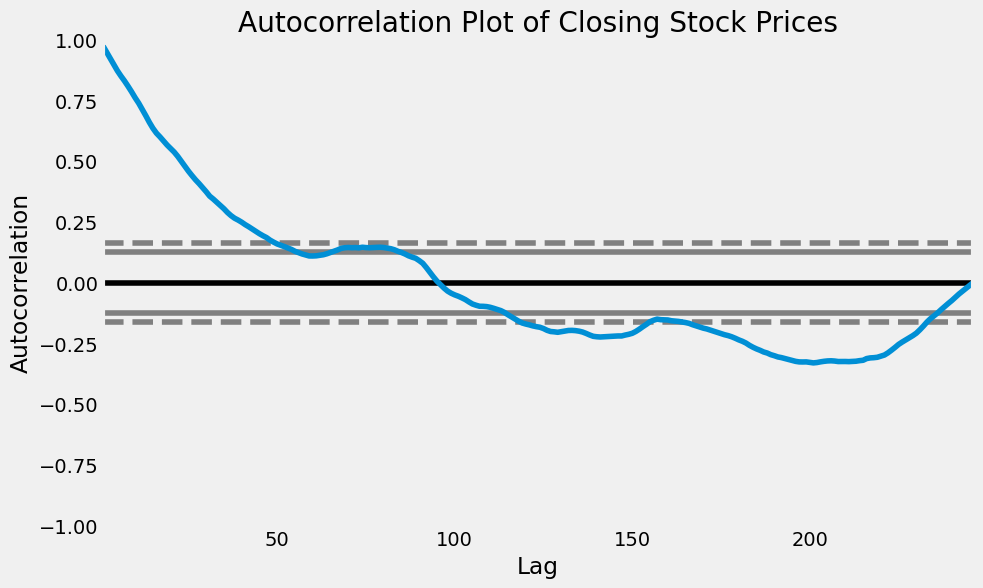

<Figure size 1000x600 with 0 Axes>

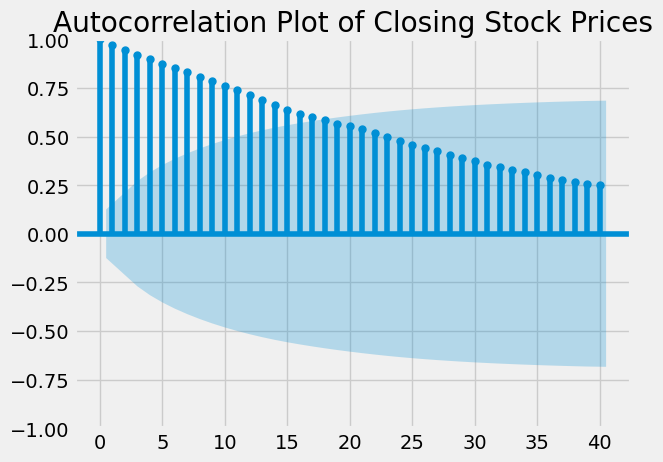

In [156]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation using pandas
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(data["Close"])
plt.title("Autocorrelation Plot of Closing Stock Prices")
plt.show()

# Lag - number of time periods

# Plot autocorrelation using pandas
plt.figure(figsize=(10, 6))
plot_acf(data["Close"], lags=40)
plt.title("Autocorrelation Plot of Closing Stock Prices")
plt.show()

In above plot, the dependence on past values seems to diminish (become less) after lag 1.

So q = 1

Find the value of p (AR):

<Figure size 1000x600 with 0 Axes>

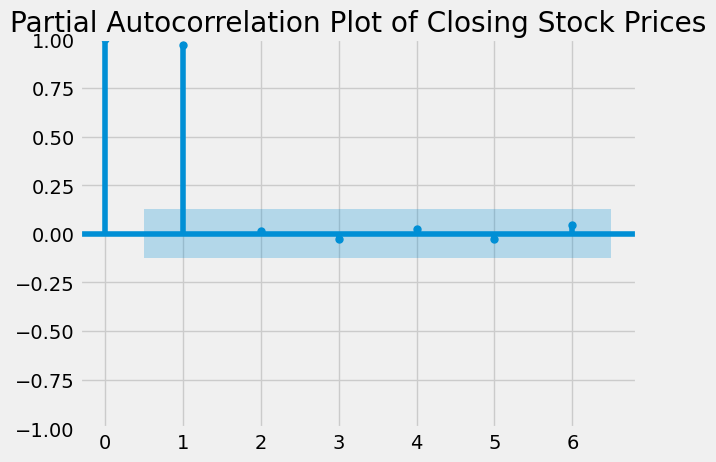

In [157]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF
plt.figure(figsize=(10, 6))
plot_pacf(data["Close"], lags=6)
plt.title("Partial Autocorrelation Plot of Closing Stock Prices")
plt.show()

In above plot, there is a single significant spike at lag 2.

So p = 2

As our data is seasonal, we should use 1 as the d value.

Now let’s build an ARIMA model:

In [158]:
p, d, q = 2, 1, 1
from statsmodels.tsa.arima.model import ARIMA

# Build ARIMA model with estimated parameters
model = ARIMA(data["Close"], order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  246
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -573.696
Date:                Tue, 11 Jun 2024   AIC                           1155.393
Time:                        07:23:49   BIC                           1169.398
Sample:                             0   HQIC                          1161.032
                                - 246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6860      1.127     -0.609      0.543      -2.894       1.522
ar.L2         -0.0097      0.140     -0.070      0.945      -0.284       0.265
ma.L1          0.6167      1.118      0.552      0.5

In [159]:
# Number of steps to forecast
forecast_steps = 10

# Make predictions
predictions = model_fit.forecast(steps=forecast_steps)

# Print predictions
print(predictions)

246    176.491358
247    176.579850
248    176.520494
249    176.560351
250    176.533587
251    176.551559
252    176.539491
253    176.547595
254    176.542153
255    176.545807
Name: predicted_mean, dtype: float64


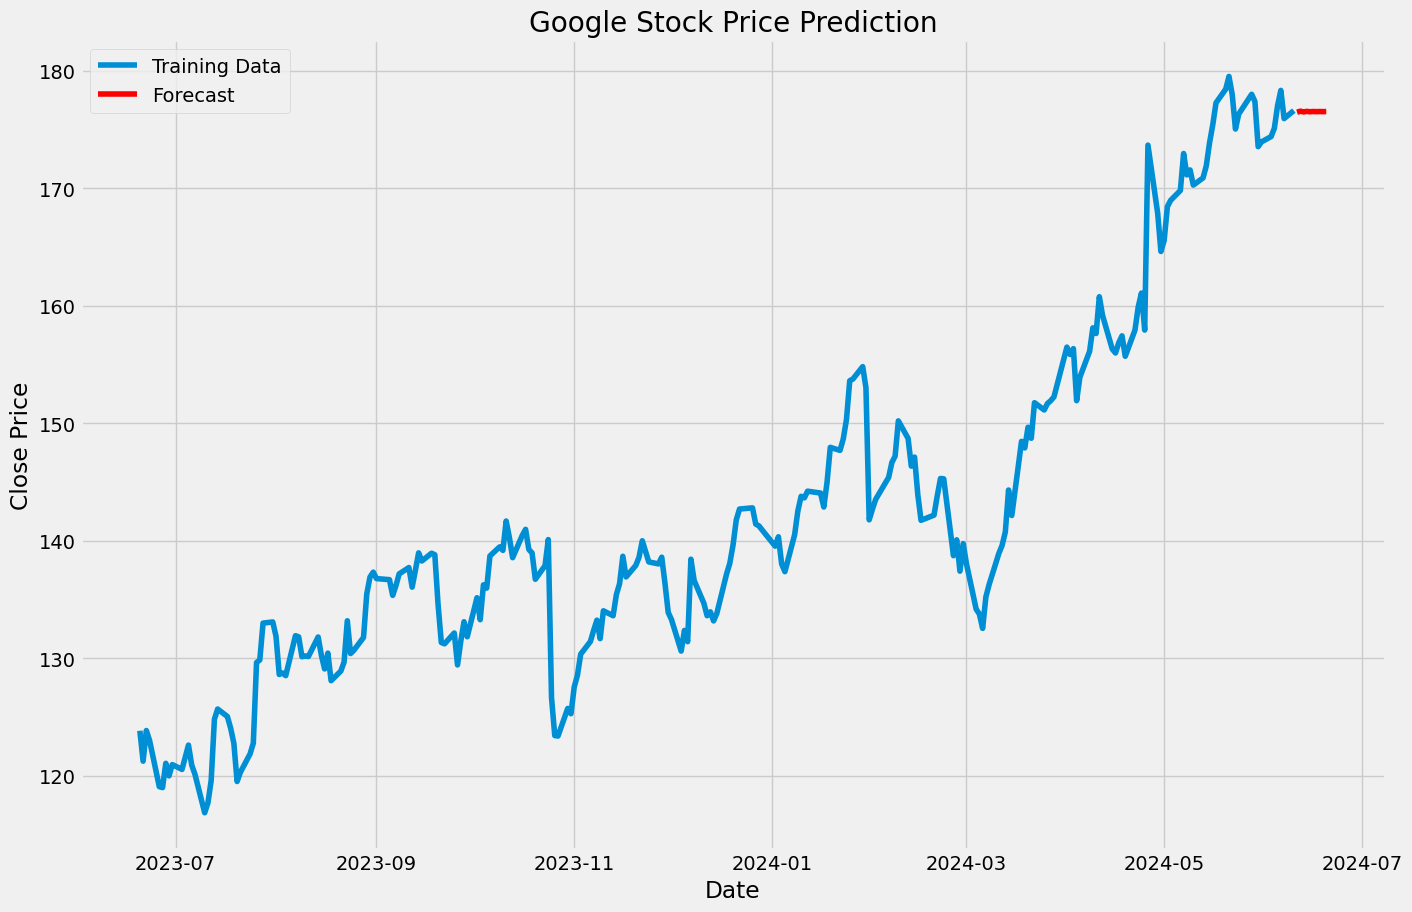

In [160]:
# Plot the original data and the predictions
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"], label="Training Data")

# Create a date range for the forecast, excluding the last date of training data
forecast_dates = pd.date_range(start=data["Date"].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Plot the forecasted values
plt.plot(forecast_dates, predictions, label="Forecast", color='red')

plt.legend()
plt.title("Google Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model:

In [161]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming seasonal period is 12 (monthly data with yearly seasonality)
model = SARIMAX(data["Close"], order=(p, d, q), seasonal_order=(p, d, q, 12))

# Fit the model
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  246
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -563.190
Date:                            Tue, 11 Jun 2024   AIC                           1140.380
Time:                                    07:23:58   BIC                           1164.537
Sample:                                         0   HQIC                          1150.121
                                            - 246                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7320      1.499     -0.488      0.625      -3.670       2.206
ar.L2         -0.0261      0.173   

Now let’s predict the future stock prices using the SARIMA model for the next 10 days:

In [162]:
# Number of steps to forecast
forecast_steps = 10

# Make predictions
predictions = model_fit.forecast(steps=forecast_steps)

# Print predictions
print(predictions)

246    176.409852
247    177.025997
248    177.060911
249    177.591491
250    177.421189
251    178.167335
252    178.636970
253    178.836267
254    179.609630
255    180.242685
Name: predicted_mean, dtype: float64


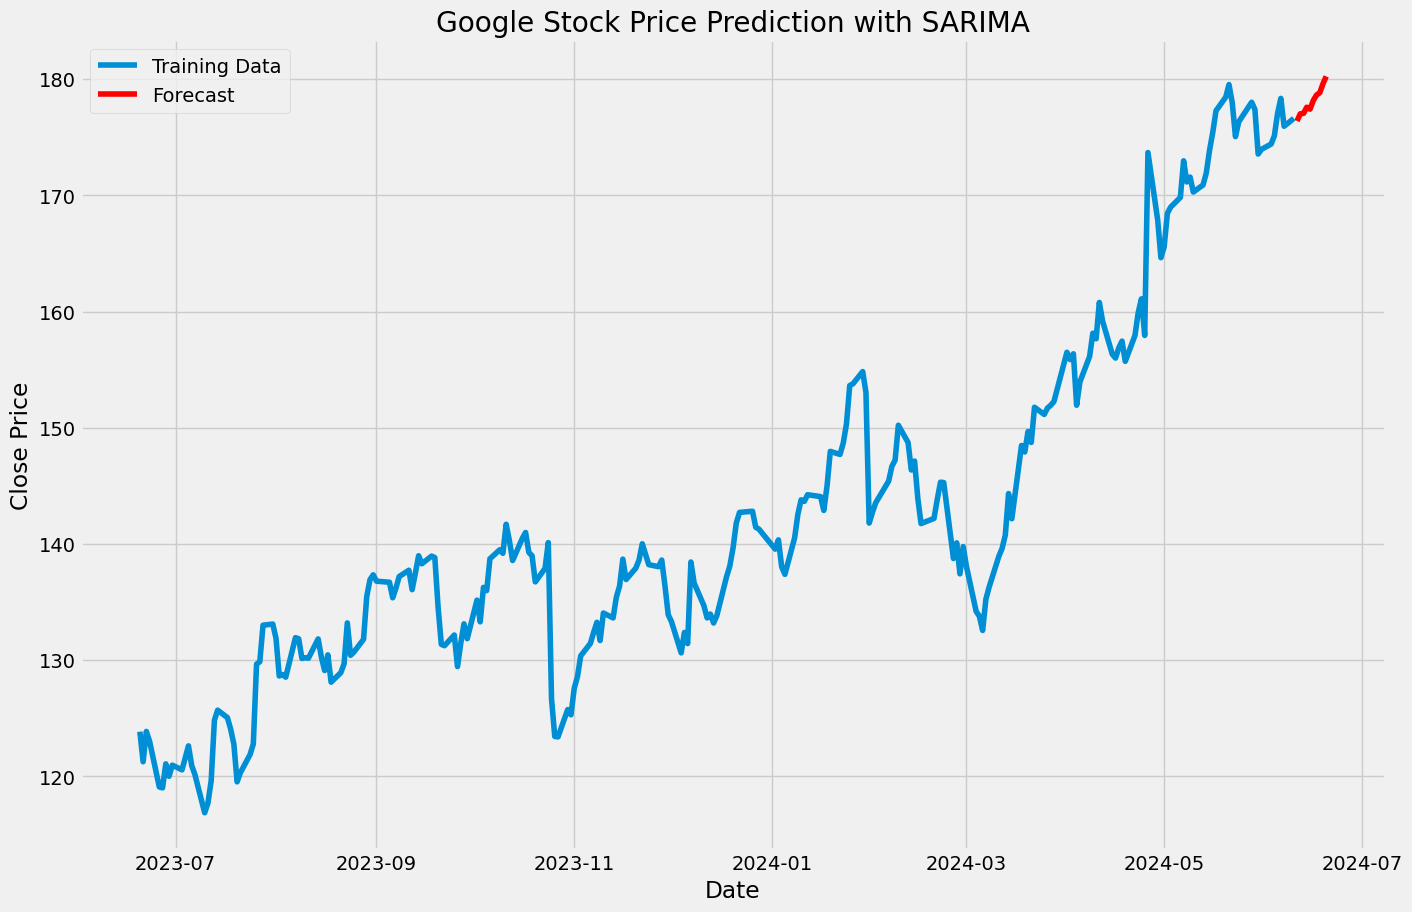

In [163]:
# Plot the original data and the predictions
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"], label="Training Data")

# Create a date range for the forecast
forecast_dates = pd.date_range(start=data["Date"].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Plot the forecasted values
plt.plot(forecast_dates, predictions, label="Forecast", color='red')

plt.legend()
plt.title("Google Stock Price Prediction with SARIMA")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()